# Assignment: Making Maps with Cartopy

### 1) Plot data from NARR

NARR is NCEP's [North American Regional Reanalysis](https://www.esrl.noaa.gov/psd/data/gridded/data.narr.html), a widely used product for studying the weather and climate of the continental US. The data is available from NOAA's [Earth System Research Laboratory](https://www.esrl.noaa.gov/) via [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP), meaing that xarray can open the data "remotely" without downloading a file.

For this problem, you should open this geopential height file:

    https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/pressure/hgt.201810.nc
    
And this precipitation file:

    https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/apcp.2018.nc
    
Your goal is to make a map that looks like the one below. It shows total precipitation on Oct. 15, 2018 in blue, plus contours of the 500 mb geopotential surface.

_Hint: examine the dataset variables and attirbutes carefully in order to determine the projection of the data._

![narr_map](cartopy_figures/narr_map.png)

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

In [2]:
url1='https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/pressure/hgt.201810.nc'
url2='https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/apcp.2018.nc'

height = xr.open_dataset(url1, drop_variables=['time_bnds'])
prcp = xr.open_dataset(url2, drop_variables=['time_bnds']);

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [3]:
height = height.sel(time='2018-10-15', level=500)

In [4]:
prcp = prcp.sel(time='2018-10-15')

In [5]:
attrs = height.Lambert_Conformal.attrs
proj = ccrs.LambertConformal(central_longitude=attrs['longitude_of_central_meridian'],
                             central_latitude=attrs['latitude_of_projection_origin'],
                             false_easting=attrs['false_easting'],
                             false_northing=attrs['false_northing'],
                             standard_parallels=attrs['standard_parallel'])

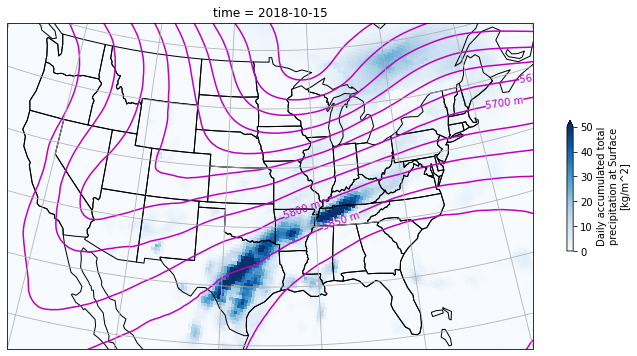

In [6]:
extent = [-120, -70, 22, 50.5]
central_lat = np.mean(extent[2:])
central_lon = np.mean(extent[:2])

plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)
ax.coastlines(resolution='110m')


ax.add_feature(cfeature.STATES.with_scale('110m'))
ax.gridlines()
con = height.hgt.plot.contour(levels=20, colors='m', transform=proj)
plt.clabel(con, fmt='%.0f m')
prcp.apcp.plot(cbar_kwargs={'shrink': 0.4}, vmax=50, cmap='Blues', transform=proj);

### 2) Antarctic Sea Ice

Download this file and then use it to plot the concentration of Antarctic Sea Ice on Aug. 7, 2017. Again, you will need to explore the file contents in order to determine the correct projection.

    ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V3/south/daily/2017/seaice_conc_daily_sh_f17_20170807_v03r01.nc
    
You'll have to download this one with `wget`.

![sea_ice_map](cartopy_figures/sea_ice_map.png)

In [7]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [8]:
import wget
ds=wget.download('ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V3/south/daily/2017/seaice_conc_daily_sh_f17_20170807_v03r01.nc')
ds_antartic=xr.open_dataset(ds)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'melt_onset_day_seaice_conc_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


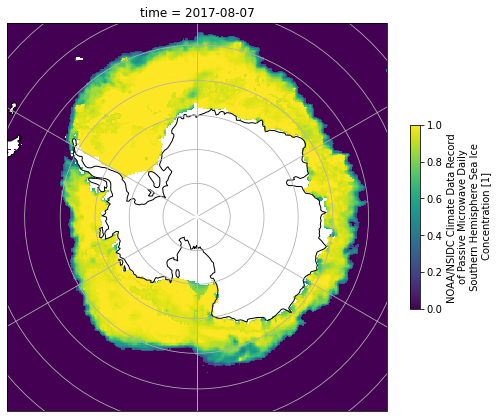

In [9]:
fig = plt.figure(figsize=(8.5, 8.5))

ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent((0, 360, -90, -55), crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
ax.gridlines(ylocs=np.linspace(-90, -40, 9, endpoint=True))
fig_antartic=ds_antartic.where(ds_antartic.seaice_conc_cdr<=1.0).seaice_conc_cdr.plot(x='longitude', y='latitude', ax=ax, transform=ccrs.PlateCarree(), shading='auto', add_colorbar=False)
fig.colorbar(fig_antartic, shrink=0.4, label='NOAA/NSIDC Climate Data Record \n of Passive Microwave Daily \n Southern Hemisphere Sea Ice \n Concentration [1]', ax=ax);

### 3) Global USGS Earthquakes

Reload the file we explored in homework 5 using pandas

    http://www.ldeo.columbia.edu/~rpa/usgs_earthquakes_2014.csv
    
and use the data to recreate this map.

![earthquake_map](cartopy_figures/earthquake_map.png)

In [10]:
import pandas as pd
url3 = 'http://www.ldeo.columbia.edu/~rpa/usgs_earthquakes_2014.csv'
df = pd.read_csv(url3)
df_large=df.nlargest(50, 'mag')

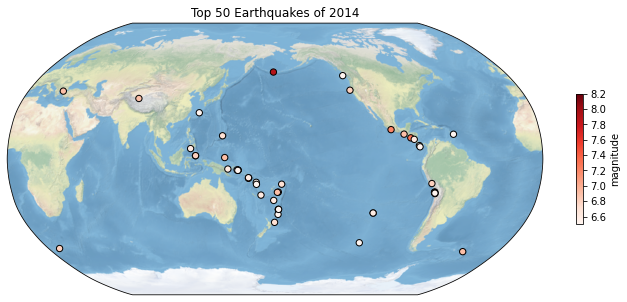

In [11]:
fig = plt.figure(figsize=(12,6))

ax=plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.stock_img()
ax.set_title('Top 50 Earthquakes of 2014')

fig_mag = df_large.plot(kind='scatter', x='longitude', y='latitude', c='mag', cmap='Reds', edgecolor='k', s=40, ax=ax, transform=ccrs.PlateCarree(), colorbar=False)
fig_mag = ax.collections[0]
fig.colorbar(fig_mag, shrink=0.4, label='magnitude', ticks=np.linspace(6.6, 8.2, 9, endpoint=True));